In [3]:
#Predicting the quality of wine
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
# Load the datasets
#This wine information comes from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Wine+Quality
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# Display the first few rows of each dataset
print("White Wine Data:")
display(white_wine.head())

print("\nRed Wine Data:")
display(red_wine.head())

White Wine Data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



Red Wine Data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# Add a column to differentiate between white and red wine
white_wine['type'] = 0
red_wine['type'] = 1

# Combine the datasets
wine_data = pd.concat([white_wine, red_wine], axis=0)

# Convert quality into a binary classification problem
wine_data['quality'] = wine_data['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Separate features and labels
X = wine_data.drop(['quality'], axis=1)
y = wine_data['quality']

# ทำการ Normalize ข้อมูล
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ใช้ SMOTE เพื่อทำ Oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# ตรวจสอบขนาดของข้อมูลหลังทำ Oversampling
print(f"Original dataset shape: {Counter(y)}")
print(f"Resampled dataset shape: {Counter(y_resampled)}")

# Reshape the data for CNN1D
X_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
print(f"New reshaped input: {X_reshaped.shape}")

Original dataset shape: Counter({0: 5220, 1: 1277})
Resampled dataset shape: Counter({0: 5220, 1: 5220})
New reshaped input: (10440, 12, 1)


In [6]:
# Define the CNN1D model architecture
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(X_reshaped.shape[1], 1)),  # Set input shape explicitly
        layers.Conv1D(32, 2, activation='relu'),  # Reduce kernel size to 2
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 2, activation='relu'),  # Reduce kernel size to 2
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 2, activation='relu'),  # Reduce kernel size to 2
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Convert y_resampled to a Numpy array
y_resampled = y_resampled.to_numpy()

# Setup K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
losses = []
conf_matrices = []
class_reports = []

for i, (train_index, test_index) in enumerate(kf.split(X_reshaped), start=1):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Create and compile model
    model = create_cnn_model()

    # Setup early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping], verbose=2)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    losses.append(loss)

    # Predict and compute confusion matrix and classification report
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred, target_names=['Not Good', 'Good']))

    # Save the model for this fold
    model.save(f'model_fold_{i}.h5')

# Average Accuracy and Loss
avg_accuracy = np.mean(accuracies)
avg_loss = np.mean(losses)

print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Loss: {avg_loss}")

Epoch 1/100
261/261 - 3s - loss: 0.7790 - accuracy: 0.7094 - val_loss: 0.5577 - val_accuracy: 0.7452 - 3s/epoch - 13ms/step
Epoch 2/100
261/261 - 1s - loss: 0.5162 - accuracy: 0.7687 - val_loss: 0.5218 - val_accuracy: 0.7486 - 952ms/epoch - 4ms/step
Epoch 3/100
261/261 - 1s - loss: 0.4824 - accuracy: 0.7905 - val_loss: 0.5037 - val_accuracy: 0.7677 - 965ms/epoch - 4ms/step
Epoch 4/100
261/261 - 1s - loss: 0.4641 - accuracy: 0.7927 - val_loss: 0.4851 - val_accuracy: 0.7802 - 940ms/epoch - 4ms/step
Epoch 5/100
261/261 - 1s - loss: 0.4576 - accuracy: 0.7989 - val_loss: 0.4713 - val_accuracy: 0.7835 - 965ms/epoch - 4ms/step
Epoch 6/100
261/261 - 1s - loss: 0.4438 - accuracy: 0.8100 - val_loss: 0.4651 - val_accuracy: 0.7874 - 1s/epoch - 4ms/step
Epoch 7/100
261/261 - 1s - loss: 0.4399 - accuracy: 0.8131 - val_loss: 0.4561 - val_accuracy: 0.7926 - 975ms/epoch - 4ms/step
Epoch 8/100
261/261 - 1s - loss: 0.4283 - accuracy: 0.8197 - val_loss: 0.4435 - val_accuracy: 0.7989 - 818ms/epoch - 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
261/261 - 5s - loss: 0.7916 - accuracy: 0.7156 - val_loss: 0.5412 - val_accuracy: 0.7605 - 5s/epoch - 18ms/step
Epoch 2/100
261/261 - 1s - loss: 0.5095 - accuracy: 0.7762 - val_loss: 0.4897 - val_accuracy: 0.7759 - 1s/epoch - 5ms/step
Epoch 3/100
261/261 - 1s - loss: 0.4788 - accuracy: 0.7892 - val_loss: 0.4859 - val_accuracy: 0.7845 - 831ms/epoch - 3ms/step
Epoch 4/100
261/261 - 1s - loss: 0.4655 - accuracy: 0.7948 - val_loss: 0.4693 - val_accuracy: 0.7821 - 830ms/epoch - 3ms/step
Epoch 5/100
261/261 - 1s - loss: 0.4519 - accuracy: 0.8035 - val_loss: 0.4605 - val_accuracy: 0.7926 - 824ms/epoch - 3ms/step
Epoch 6/100
261/261 - 1s - loss: 0.4365 - accuracy: 0.8084 - val_loss: 0.4539 - val_accuracy: 0.7989 - 810ms/epoch - 3ms/step
Epoch 7/100
261/261 - 1s - loss: 0.4315 - accuracy: 0.8136 - val_loss: 0.4490 - val_accuracy: 0.7969 - 850ms/epoch - 3ms/step
Epoch 8/100
261/261 - 1s - loss: 0.4233 - accuracy: 0.8199 - val_loss: 0.4636 - val_accuracy: 0.7917 - 826ms/epoch - 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
261/261 - 3s - loss: 0.7761 - accuracy: 0.7160 - val_loss: 0.5225 - val_accuracy: 0.7797 - 3s/epoch - 11ms/step
Epoch 2/100
261/261 - 2s - loss: 0.5075 - accuracy: 0.7766 - val_loss: 0.4813 - val_accuracy: 0.7787 - 2s/epoch - 7ms/step
Epoch 3/100
261/261 - 1s - loss: 0.4815 - accuracy: 0.7817 - val_loss: 0.4537 - val_accuracy: 0.8041 - 1s/epoch - 5ms/step
Epoch 4/100
261/261 - 1s - loss: 0.4621 - accuracy: 0.7989 - val_loss: 0.4454 - val_accuracy: 0.8113 - 1s/epoch - 5ms/step
Epoch 5/100
261/261 - 3s - loss: 0.4562 - accuracy: 0.8003 - val_loss: 0.4436 - val_accuracy: 0.8070 - 3s/epoch - 10ms/step
Epoch 6/100
261/261 - 1s - loss: 0.4395 - accuracy: 0.8084 - val_loss: 0.4439 - val_accuracy: 0.8142 - 843ms/epoch - 3ms/step
Epoch 7/100
261/261 - 1s - loss: 0.4371 - accuracy: 0.8094 - val_loss: 0.4284 - val_accuracy: 0.8252 - 833ms/epoch - 3ms/step
Epoch 8/100
261/261 - 1s - loss: 0.4266 - accuracy: 0.8167 - val_loss: 0.4261 - val_accuracy: 0.8142 - 785ms/epoch - 3ms/step
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
261/261 - 3s - loss: 0.7896 - accuracy: 0.7087 - val_loss: 0.5203 - val_accuracy: 0.7826 - 3s/epoch - 11ms/step
Epoch 2/100
261/261 - 1s - loss: 0.5278 - accuracy: 0.7627 - val_loss: 0.4659 - val_accuracy: 0.7878 - 1s/epoch - 5ms/step
Epoch 3/100
261/261 - 1s - loss: 0.4881 - accuracy: 0.7829 - val_loss: 0.4430 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 4/100
261/261 - 1s - loss: 0.4709 - accuracy: 0.7914 - val_loss: 0.4508 - val_accuracy: 0.8075 - 952ms/epoch - 4ms/step
Epoch 5/100
261/261 - 1s - loss: 0.4611 - accuracy: 0.7993 - val_loss: 0.4327 - val_accuracy: 0.8094 - 827ms/epoch - 3ms/step
Epoch 6/100
261/261 - 1s - loss: 0.4483 - accuracy: 0.8048 - val_loss: 0.4161 - val_accuracy: 0.8209 - 814ms/epoch - 3ms/step
Epoch 7/100
261/261 - 1s - loss: 0.4390 - accuracy: 0.8124 - val_loss: 0.4245 - val_accuracy: 0.8194 - 767ms/epoch - 3ms/step
Epoch 8/100
261/261 - 1s - loss: 0.4320 - accuracy: 0.8151 - val_loss: 0.4069 - val_accuracy: 0.8233 - 834ms/epoch - 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
261/261 - 2s - loss: 0.7894 - accuracy: 0.7110 - val_loss: 0.5454 - val_accuracy: 0.7634 - 2s/epoch - 8ms/step
Epoch 2/100
261/261 - 1s - loss: 0.5272 - accuracy: 0.7662 - val_loss: 0.4859 - val_accuracy: 0.7859 - 879ms/epoch - 3ms/step
Epoch 3/100
261/261 - 1s - loss: 0.4915 - accuracy: 0.7840 - val_loss: 0.4615 - val_accuracy: 0.7960 - 1s/epoch - 5ms/step
Epoch 4/100
261/261 - 1s - loss: 0.4745 - accuracy: 0.7900 - val_loss: 0.4589 - val_accuracy: 0.7941 - 1s/epoch - 4ms/step
Epoch 5/100
261/261 - 1s - loss: 0.4642 - accuracy: 0.7989 - val_loss: 0.4414 - val_accuracy: 0.8065 - 1s/epoch - 5ms/step
Epoch 6/100
261/261 - 1s - loss: 0.4540 - accuracy: 0.8003 - val_loss: 0.4398 - val_accuracy: 0.7984 - 1s/epoch - 6ms/step
Epoch 7/100
261/261 - 1s - loss: 0.4439 - accuracy: 0.8093 - val_loss: 0.4279 - val_accuracy: 0.8127 - 1s/epoch - 6ms/step
Epoch 8/100
261/261 - 1s - loss: 0.4344 - accuracy: 0.8138 - val_loss: 0.4299 - val_accuracy: 0.8075 - 1s/epoch - 5ms/step
Epoch 9/100
2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training on 80% of the data, Testing on 20% of the data.
Number of samples used for training: 8352
Number of samples used for testing: 2088


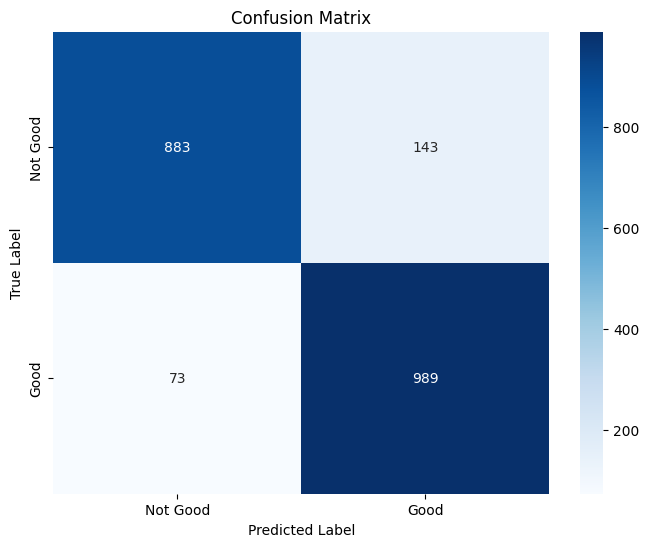

Classification Report:

              precision    recall  f1-score   support

    Not Good       0.92      0.86      0.89      1026
        Good       0.87      0.93      0.90      1062

    accuracy                           0.90      2088
   macro avg       0.90      0.90      0.90      2088
weighted avg       0.90      0.90      0.90      2088



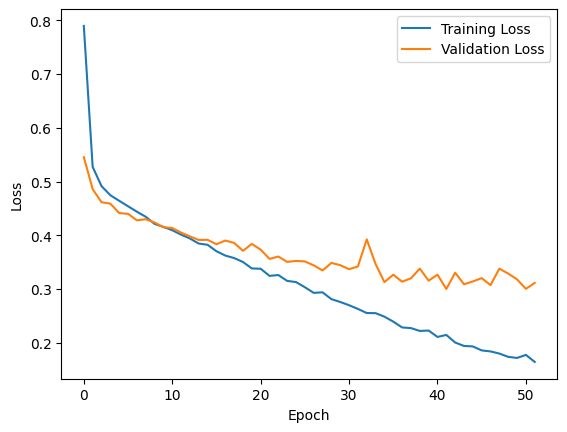

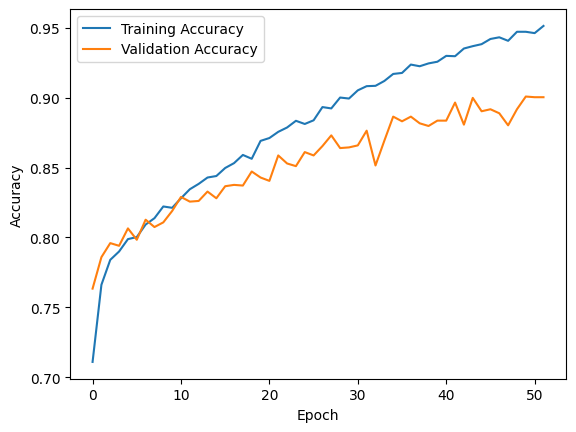

In [8]:
# Display train-test split percentage and sample counts
train_percentage = (kf.get_n_splits() - 1) / kf.get_n_splits() * 100
test_percentage = 100 / kf.get_n_splits()

# Number of samples for training and testing
train_sample_count = len(X_train)
test_sample_count = len(X_test)

print(f"Training on {train_percentage:.0f}% of the data, Testing on {test_percentage:.0f}% of the data.")
print(f"Number of samples used for training: {train_sample_count}")
print(f"Number of samples used for testing: {test_sample_count}")

# Plot the confusion matrix
conf_matrix = conf_matrices[-1]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Good', 'Good'], yticklabels=['Not Good', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report for the last fold
print("Classification Report:\n")
print(class_reports[-1])

# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

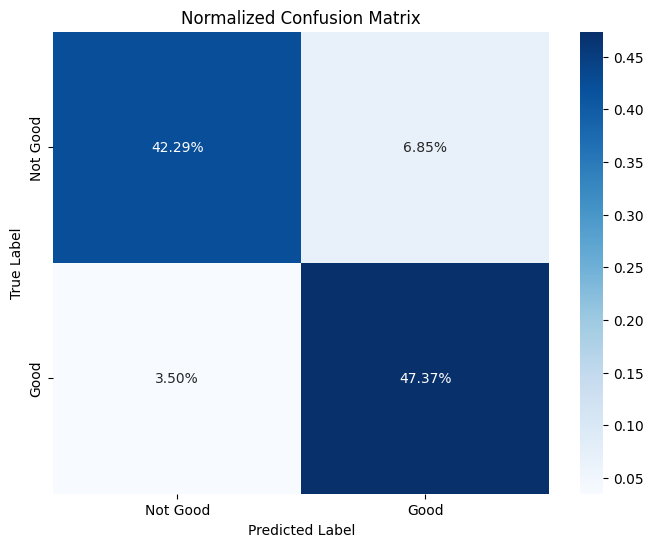

66/66 [==============================] - 0s 2ms/step


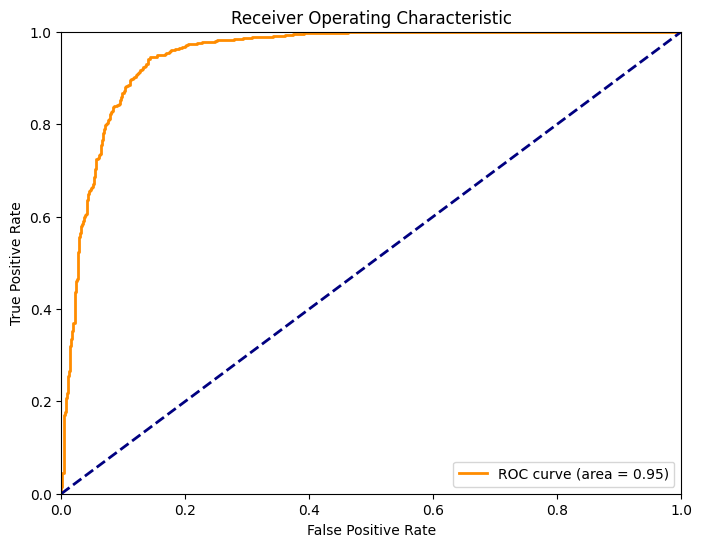

66/66 [==============================] - 0s 2ms/step


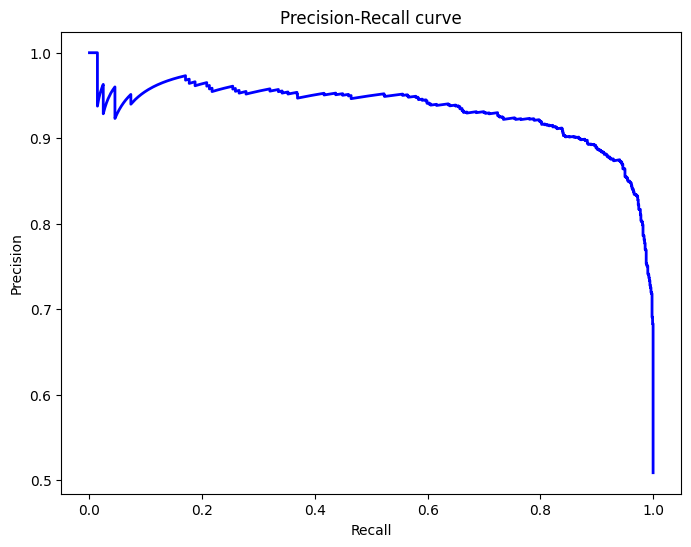

In [9]:
# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Not Good', 'Good'], yticklabels=['Not Good', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict(X_test))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [10]:
# Save the model as a .h5 file after training
model.save('final_wine_quality_model.h5')
print("Model saved as 'final_wine_quality_model_CNN.h5'")

Model saved as 'final_wine_quality_model_CNN.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
